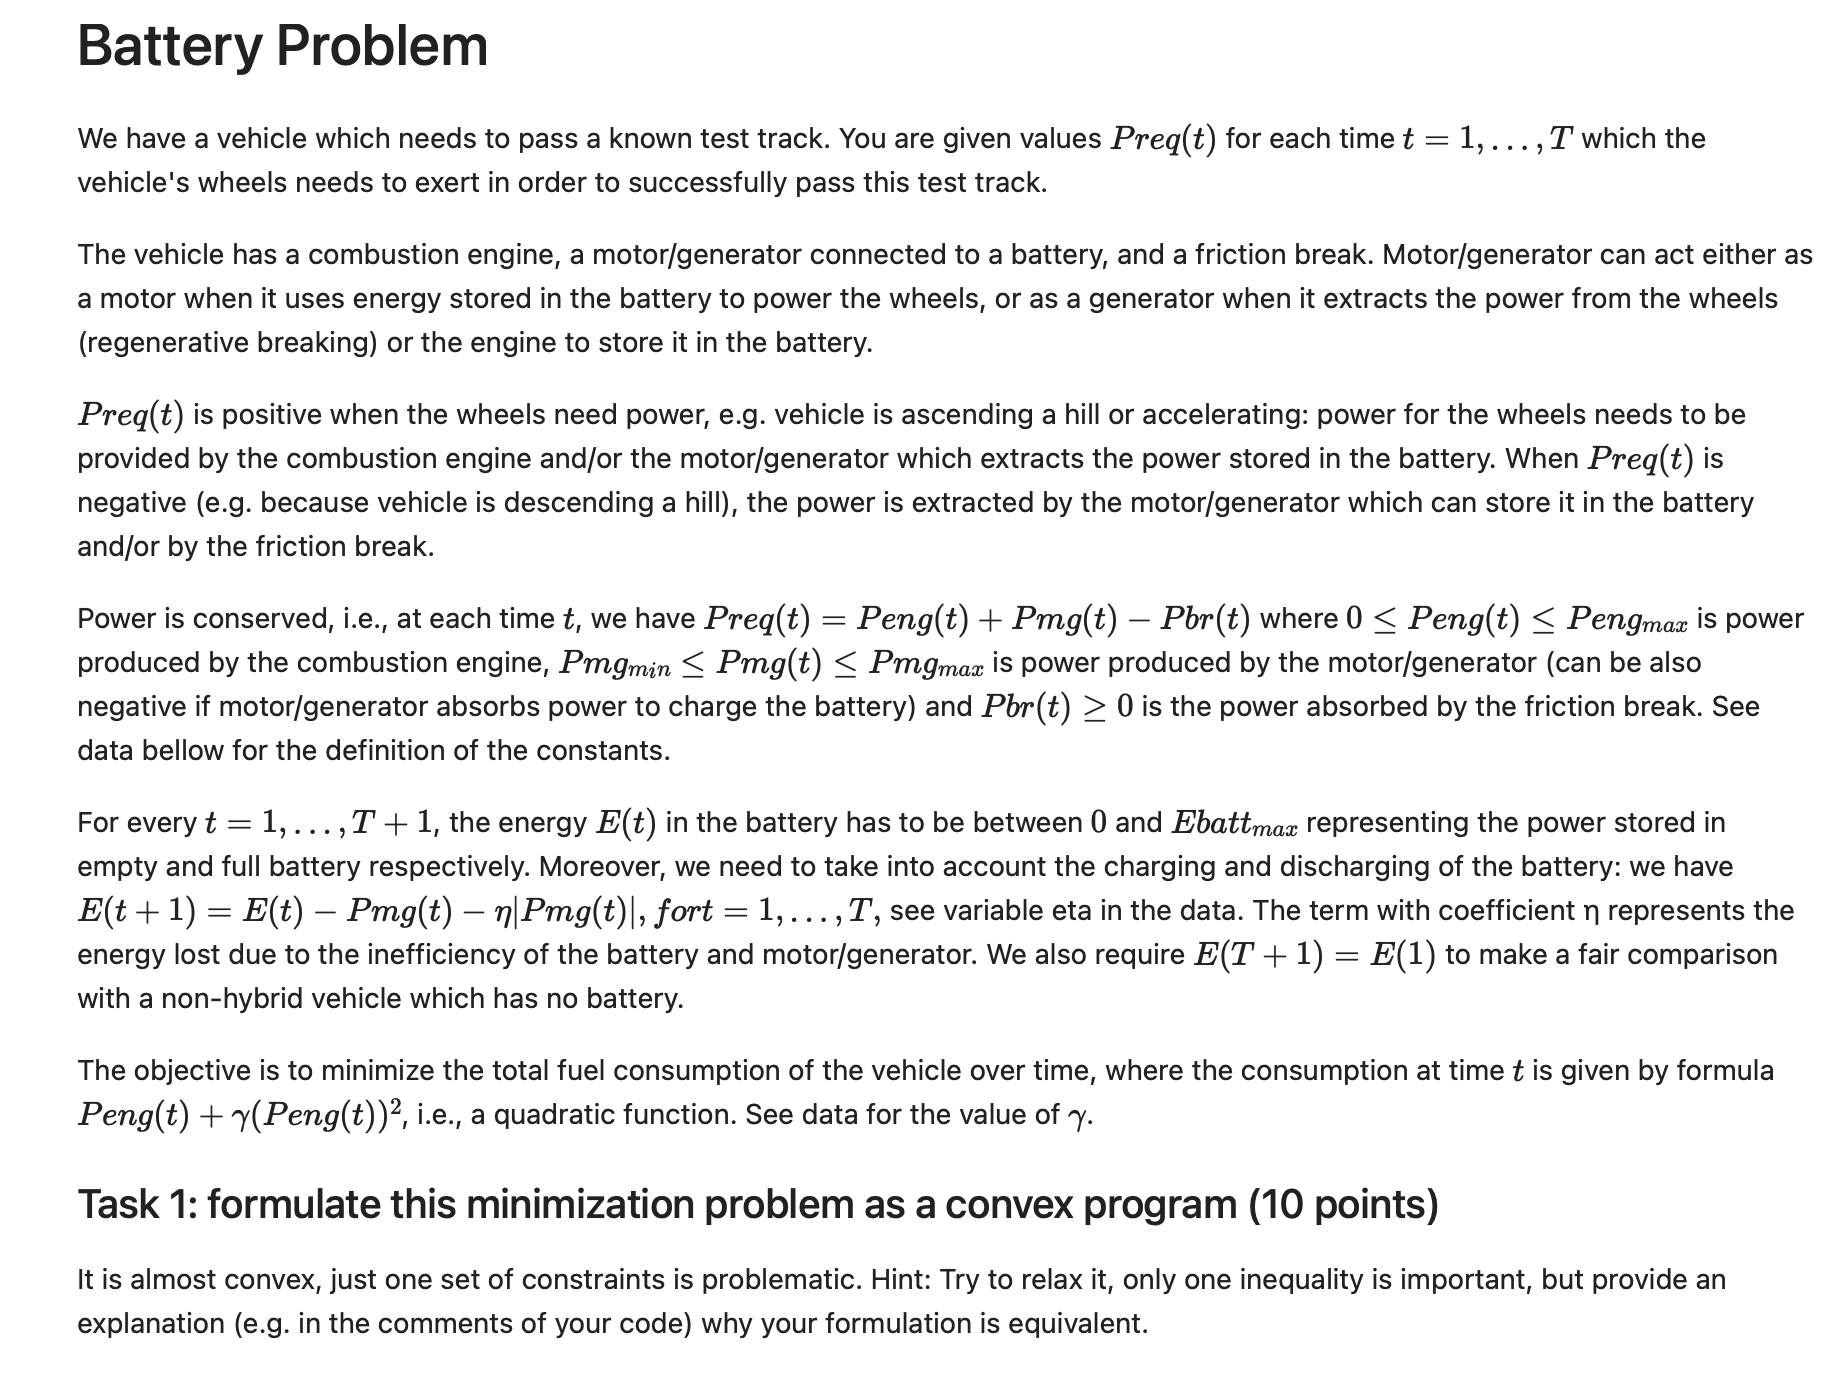

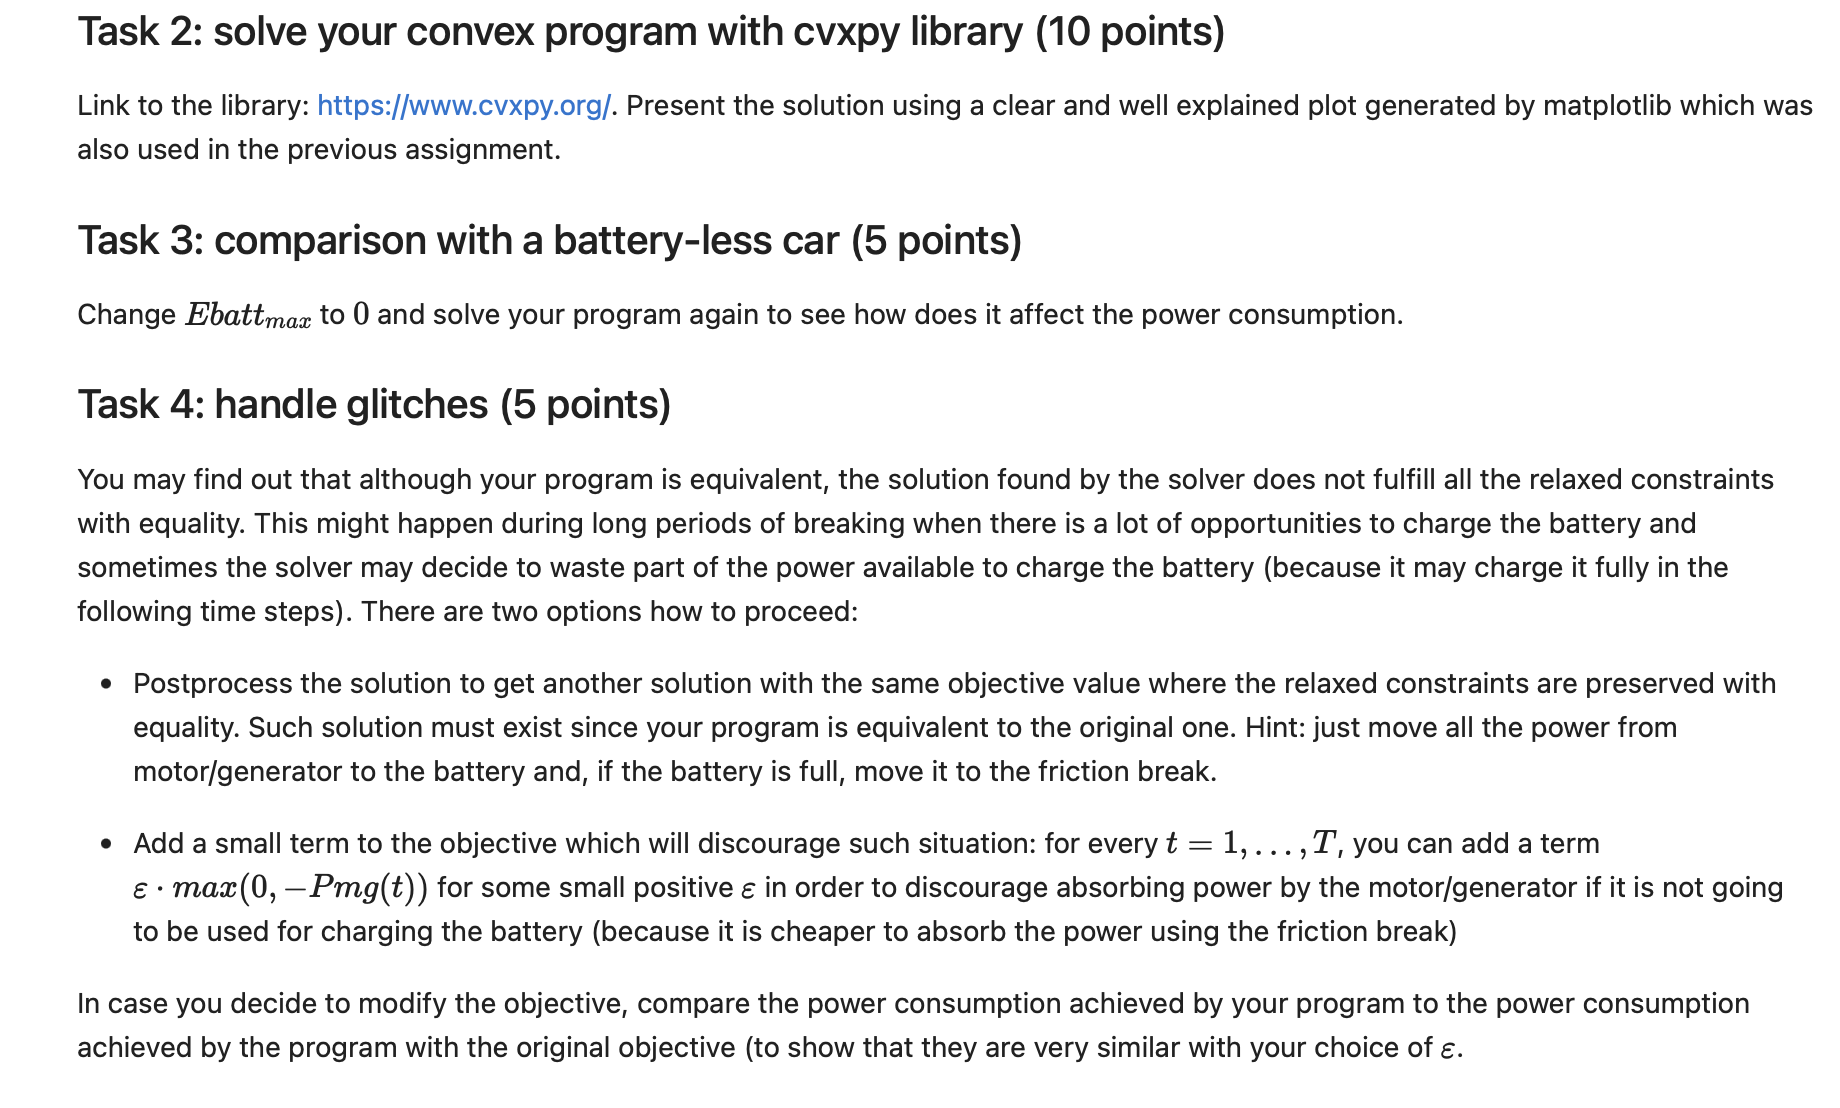

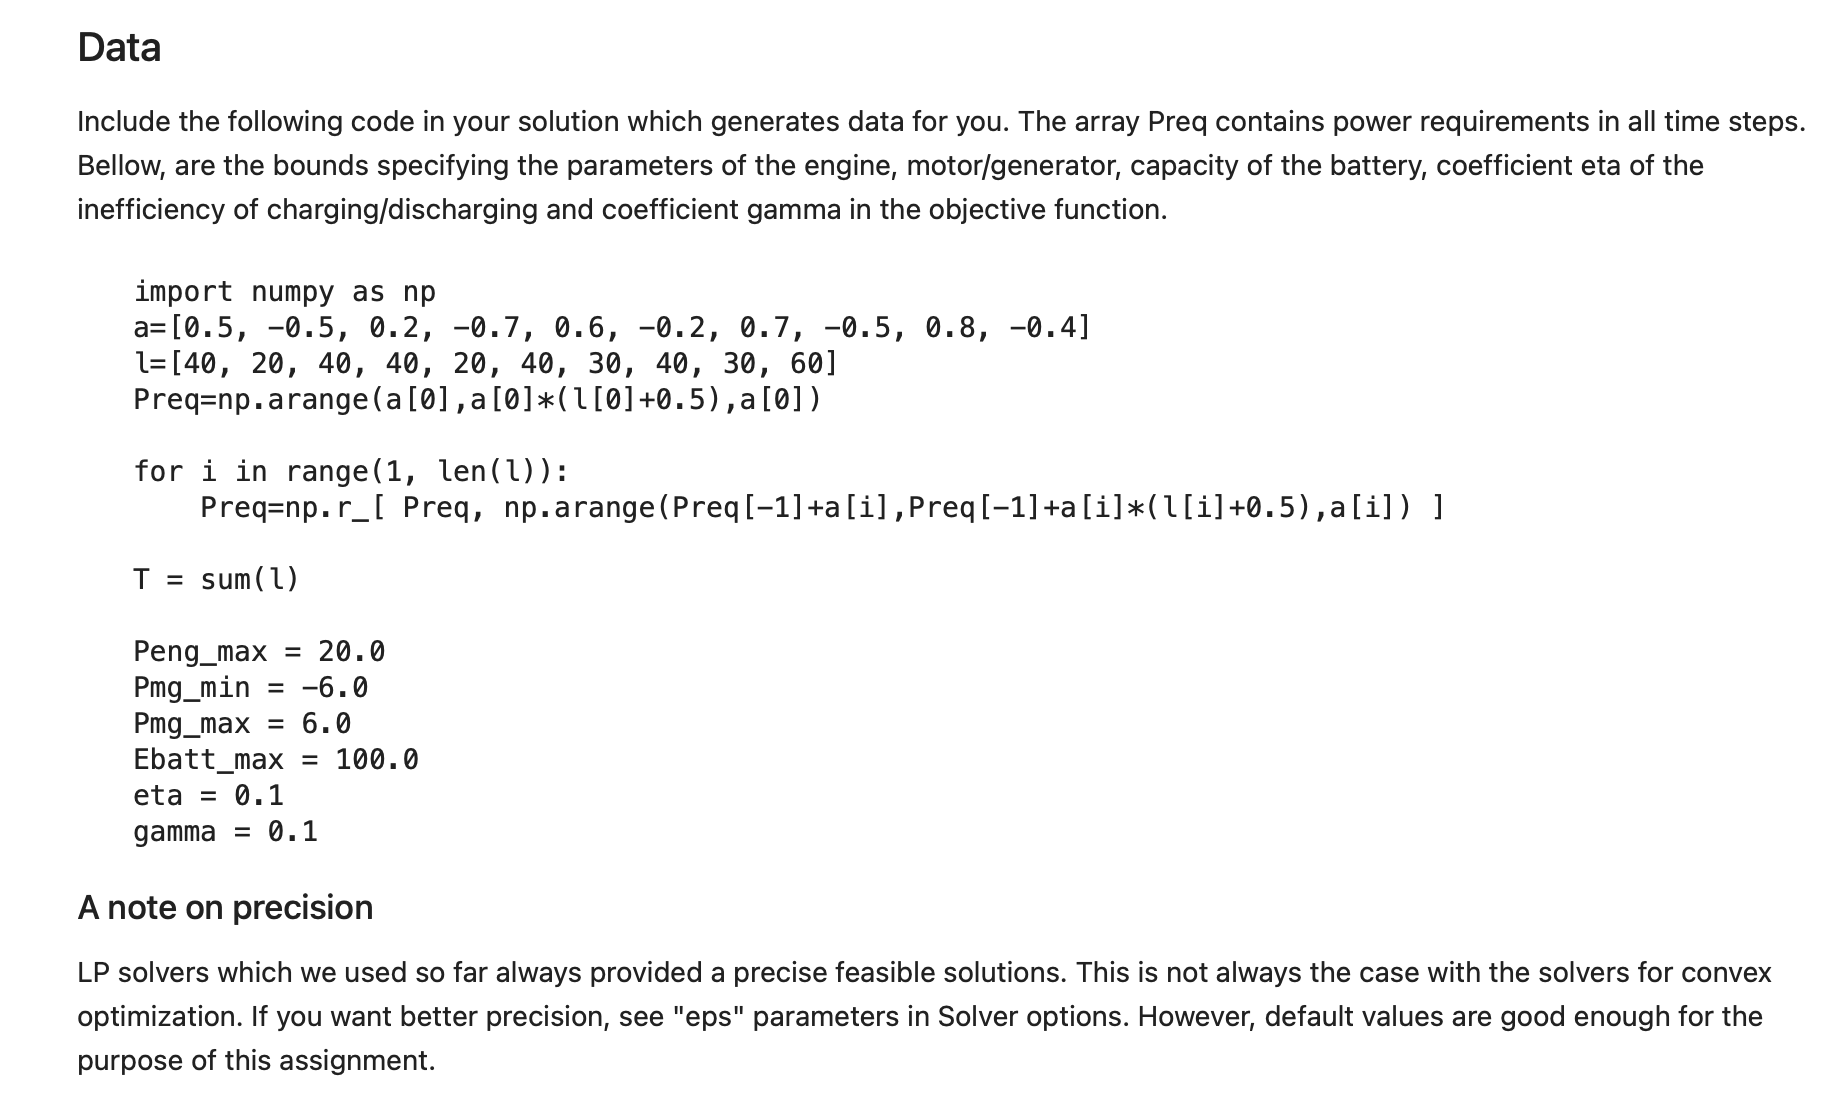

In [2]:
from IPython.display import Image, display

def display_images(image_files):
    for image_file in image_files:
        display(Image(filename=image_file))

image_files = ["./Battery-1.png", "./Battery-2.png", "./Battery-3.png"]  
display_images(image_files)

In [4]:
import numpy as np
import cvxpy as cp

a=[0.5, -0.5, 0.2, -0.7, 0.6, -0.2, 0.7, -0.5, 0.8, -0.4]
l=[40, 20, 40, 40, 20, 40, 30, 40, 30, 60]
Preq=np.arange(a[0],a[0]*(l[0]+0.5),a[0])
for i in range(1, len(l)):
    Preq=np.r_[ Preq, np.arange(Preq[-1]+a[i],Preq[-1]+a[i]*(l[i]+0.5),a[i]) ]

T = sum(l)

Peng_max = 20.0
Pmg_min = -6.0
Pmg_max = 6.0
eta = 0.1
gamma = 0.1


# In the original problem, the constraint involving the absolute value is non-convex. 
# To address this issue, first I relaxed the constraint from '==' to '<=' and 
# then replaced it with two inequalities leveraging the property of absolute values,
# where |x| < y is equivalent to -y < x < y.
# This relaxation can be interpreted as allowing for the potential loss of energy in the battery at each step.
# The optimization problem will aim to tighten these constraints trying to keep E[t+1] large.
# This method ensures a more efficient solution that meets power demands for the motor
# while accurately representing battery energy updates and minimizing fuel consumption.

def solve_problem(Ebatt_max):
    
    Peng = cp.Variable(T)
    Pmg = cp.Variable(T)
    Pbr = cp.Variable(T)
    E = cp.Variable(T+1)

    epsilon = 0.0001

    c = 0
    constraints = []

    constraints += [E[T] == E[0]]

    for t in range(T):
        c += cp.sum(Peng[t] + gamma * cp.square(Peng[t]) +  epsilon * cp.maximum(0, - Pmg[t]))

        constraints += [ Preq[t] == Peng[t] + Pmg[t] - Pbr[t],
                   E[t+1] - E[t] + Pmg[t] <= eta * Pmg[t],
                   E[t+1] - E[t] + Pmg[t] <= - eta * Pmg[t],
                   Peng[t] <= Peng_max,
                   Peng[t] >= 0,
                   Pmg[t] <= Pmg_max,
                   Pmg[t] >= Pmg_min,
                   Pbr[t] >= 0,
                   E[t] <= Ebatt_max,
                   E[t] >= 0]

    problem = cp.Problem(cp.Minimize(c), constraints)

    problem.solve(solver=cp.OSQP, eps_abs=1e-10, eps_rel=1e-10)
 
    retval = {
        'Peng': [float(Peng[t].value) for t in range(T)],
        'Pmg': [float(Pmg[t].value) for t in range(T)],
        'Pbr': [float(Pbr[t].value) for t in range(T)],
        'E': [float(E[t].value) for t in range(T+1)],
        'Sol': problem.value
    }

    return retval

def car_with_battery():
    return solve_problem(100.0)

def car_without_battery():
    return solve_problem(0)

res1= car_with_battery() 
print("With battery:")
print('Sol:', res1['Sol']) 

res2= car_without_battery() 
print("\nWithout battery:")
print('Sol:', res2['Sol']) 

for t in range(T):
   error = abs(res1['E'][t+1]-res1['E'][t]+res1['Pmg'][t]+ eta* abs(res1['Pmg'][t]))
   if error> 0.0003:
       print(error)


for t in range(T):
   error = abs(res2['E'][t+1]-res2['E'][t]+res2['Pmg'][t]+ eta* abs(res2['Pmg'][t]))
   if error >0.0003:
       print(error)


With battery:
Sol: 5077.561790531341

Without battery:
Sol: 5896.808999999873
